# Setup

Check requirements.txt ...

In [1]:
! pip install -r "requirements.txt"


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


... and load packages

In [2]:
# Import of all packages used in this notebook
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pycountry
from pycountry_convert.convert_country_alpha2_to_continent_code \
    import country_alpha2_to_continent_code
from pycountry_convert.convert_continent_code_to_continent_name \
    import convert_continent_code_to_continent_name

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import PredictionErrorDisplay

from column_names import get_column_names
from utils.categoricalTransformer import CategoricalTransformer
from utils.numericalTransformer import NumericalTransformer

from scipy.stats.mstats import pearsonr


# Magic commands
%matplotlib inline
%load_ext pycodestyle_magic
# %pycodestyle_on

Download and unzip dataset, if necessary.

In [3]:
filename = 'cost-of-living_v2.csv'

# check if file already exists
if os.path.exists(filename):
    print('File {} exists.'.format(filename))

else:

    zip_file = 'global-cost-of-living.zip'

    # check if kaggle zip-file already exists
    if os.path.exists(zip_file):
        print('File {} exists.'.format(zip_file))
    else:
        # Download files from kaggle
        ! kaggle datasets download -d "mvieira101/global-cost-of-living"
    # end if

    # Unpacking files
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('')
    print('Unpacking {}.'.format(zip_file))

# end if

File cost-of-living_v2.csv exists.


Import dataset

In [4]:
# import dataset
df = pd.read_csv(filename)

# give the columns informative names
df.columns = get_column_names()

global_random_state = 42

create fig-folder

In [5]:
if not os.path.isdir('fig'):
    os.mkdir('fig')

# Data Analysis

## Basics

Shape of the dataset

In [6]:
df.shape

(4956, 58)

Let's look at the column names.

In [7]:
df.columns

Index(['city', 'country', 'meal_cheap', 'meal_3_course', 'mc_meal',
       'beer_domestic_restaurant', 'beer_imported_restaurant',
       'capuccino_restaurant', 'coke_restaurant', 'water_restaurant', 'milk',
       'bread', 'rice', 'eggs', 'cheese', 'chicken', 'beef_equivalent',
       'apples', 'banana', 'oranges', 'tomato', 'potato', 'onion', 'lettuce',
       'water_market', 'wine_market', 'beer_domestic_market',
       'beer_imported_market', 'cigarettes', 'transport_one_way',
       'transport_monthly', 'taxi_start', 'taxi_1km', 'taxi_1hour_waiting',
       'gasoline', 'volkswagen_golf', 'toyota_corolla', 'living_basics',
       'phone', 'internet', 'fitness_club', 'tennis_court', 'cinema',
       'preschool', 'primary_school', 'jeans', 'dress', 'running_shoes',
       'leather_shoes', 'apartment_rent_1_room_centre',
       'apartment_rent_1_room_outside', 'apartment_rent_3_room_centre',
       'apartment_rent_3_room_outside', 'apartment_price_centre',
       'apartment_price_out

The dataset contains cities in several countries. For each city there are several costs, e.g. for groceries and beverages, transportation, leisure time, clothing, housing.
Additionally it contains information about salaries and mortgages.
The last columns is called `data_quality` and contains a flag. It is 0 if Numbeo considers that more contributors are needed to increase data quality and 1 elsewise.

Let's see how many rows have sufficient data and drop the others.

In [8]:
# check dtype of column data_quality
col_quality = 'data_quality'
print('Column {} has type {}.'.format(
    col_quality,
    df[col_quality].dtype
))

# convert dtype of data quality column to bool
df[col_quality] = pd.Series(df[col_quality], dtype=bool)

# count rows with good data quality
print('{} of {} cities have good data quality!'.format(
    df[col_quality].sum(),
    df.shape[0]
))

# drop all rows with bad data quality
df_quality = df.loc[df[col_quality], :]
df_quality = df_quality.drop(labels=col_quality, axis=1)

Column data_quality has type int64.
923 of 4956 cities have good data quality!


Lets count the missing values

In [9]:
df_missing = (df_quality.shape[0]-df_quality.count())
df_missing = df_missing.sort_values(ascending=False)

print('{} of {} columns do not have any missing values\n'.format(
    df_missing.value_counts()[0],
    df_missing.shape[0]
))

print('Missing values by columns:\n{}'.format(
    df_missing
))

30 of 57 columns do not have any missing values

Missing values by columns:
primary_school                   75
phone                            28
apartment_price_outside          25
taxi_1hour_waiting               22
apartment_price_centre           21
tennis_court                     18
mortgage_interest                13
transport_monthly                13
preschool                        11
toyota_corolla                   10
taxi_1km                          5
volkswagen_golf                   4
beer_imported_market              4
tomato                            3
beer_domestic_market              3
taxi_start                        2
wine_market                       2
cigarettes                        2
beer_imported_restaurant          1
eggs                              1
salary                            1
cinema                            1
coke_restaurant                   1
beer_domestic_restaurant          1
chicken                           1
running_shoes           

In [10]:
# implementation of a nan checker we will need later
def na_check(df, cols):
    """
    Checks for na values in the columns cols of Dataframe df.
    Outputs True if any of the columns has a na value and False elsewise.
    """
    contains_na = df.loc[:, cols].isna().any(axis=1).any()
    return contains_na

Let's look at the column datatypes

In [11]:
df_quality.dtypes.value_counts()

float64    55
object      2
dtype: int64

In [12]:
df_quality.select_dtypes(include='object').columns

Index(['city', 'country'], dtype='object')

This shows that all columns except `city` and `country` are numerical.

Let's take a look at the distributions of all columns next. First we will have a look at the countries.

Text(0, 0.5, '# of cities')

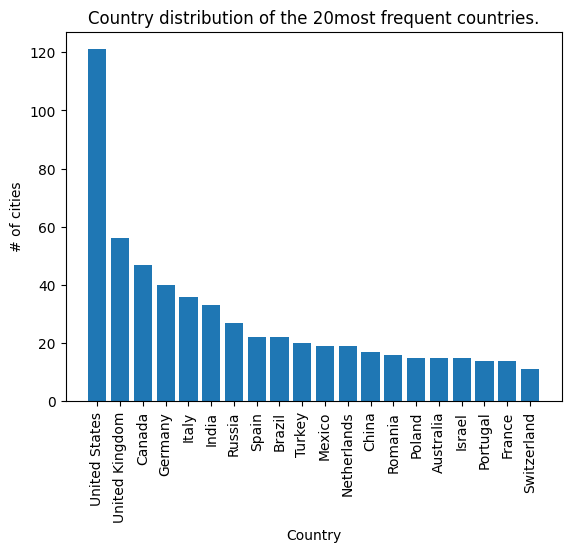

In [13]:
def plot_categorical_hist(categorical, limit=0):
    """
    Plot a histogram for categoricals with 90° ticks.
    Limit output to the highest 'limit' counts.
    """
    categorical_counts = categorical.value_counts()

    limit = limit if limit != 0 else categorical_counts.shape[0]

    categorical_dict = categorical_counts.iloc[:limit].to_dict()

    fig, ax = plt.subplots(1, 1)
    plt.bar(categorical_dict.keys(), categorical_dict.values())
    ax.tick_params(axis='x', labelrotation=90)

    return ax
# end def


n_countries = 20
str_title = (f'Country distribution of the {n_countries}'
             'most frequent countries.')

ax = plot_categorical_hist(df_quality['country'], limit=n_countries)
ax.set_title(str_title)
ax.set_xlabel('Country')
ax.set_ylabel('# of cities')

Looks like cities in the US and European cities are highly present in this dataset.

This raises the question, which continents the cities are located on.

In [14]:
def convert_country_to_continent(country_name):
    """
    Function provides continent name for a country name.
    """

    # initialize continent_name and country_obj
    continent_name = 'Unknown'
    country_obj = []

    # manual fix for 2 countries
    if country_name == 'Ivory Coast':
        country_name = 'Côte d\'Ivoire'

    elif country_name == 'Kosovo (Disputed Territory)':
        country_name = 'Kosovo'

    # end if

    # get the pycountry.Country object
    try:
        country_obj = pycountry.countries.lookup(country_name)

    except LookupError:
        # Print info
        print(('Could not find {} with lookup function. '
               'Trying search_fuzzy.').format(
            country_name
        ))

        # try search fuzzy instead
        try:
            country_list = pycountry.countries.search_fuzzy(country_name)

            # print information whether multiple results occured
            if len(country_list) > 1:
                print(('Expected only one country during '
                       'search_fuzzy, but got {}!.').format(
                    len(country_list)
                ))

            else:
                print('search_fuzzy was successful with exactly one result!')
            # end if

            country_obj = country_list[0]
            print('Using "{}" for "{}".'.format(
                country_obj.name,
                country_name
            ))

        except LookupError:
            print('{} not found. Country will have no continent'.format(
                country_name
            ))

        # end try
    # end try

    if str(type(country_obj)) == \
       "<class 'pycountry.db.Country'>":  # isinstance does not work
        # convert alpha_2 value of country object into continent name
        country_code = country_obj.alpha_2
        continent_code = country_alpha2_to_continent_code(country_code)
        continent_name = convert_continent_code_to_continent_name(
                continent_code
            )
    # end if

    return continent_name
# end def


# add a continen column to the dataset
df_quality['continent'] = df_quality['country'].apply(
        convert_country_to_continent
    )

Could not find Russia with lookup function. Trying search_fuzzy.
search_fuzzy was successful with exactly one result!
Using "Russian Federation" for "Russia".
Could not find Iran with lookup function. Trying search_fuzzy.
Expected only one country during search_fuzzy, but got 7!.
Using "Iran, Islamic Republic of" for "Iran".
Could not find Iran with lookup function. Trying search_fuzzy.
Expected only one country during search_fuzzy, but got 7!.
Using "Iran, Islamic Republic of" for "Iran".
Could not find Iran with lookup function. Trying search_fuzzy.
Expected only one country during search_fuzzy, but got 7!.
Using "Iran, Islamic Republic of" for "Iran".
Could not find Syria with lookup function. Trying search_fuzzy.
search_fuzzy was successful with exactly one result!
Using "Syrian Arab Republic" for "Syria".
Could not find Russia with lookup function. Trying search_fuzzy.
search_fuzzy was successful with exactly one result!
Using "Russian Federation" for "Russia".
Could not find Iran

Text(0, 0.5, '# of cities')

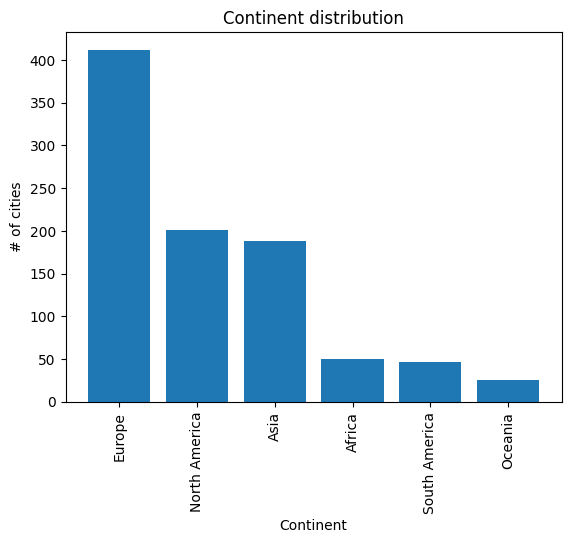

In [15]:
ax = plot_categorical_hist(df_quality['continent'])
ax.set_title('Continent distribution')
ax.set_xlabel('Continent')
ax.set_ylabel('# of cities')

This confirms our first impression: Most of the cities are in Europe and Nothern America. Unknown refers to countries, where the continent could not be automatically assigned.

Let's look at the other distributions

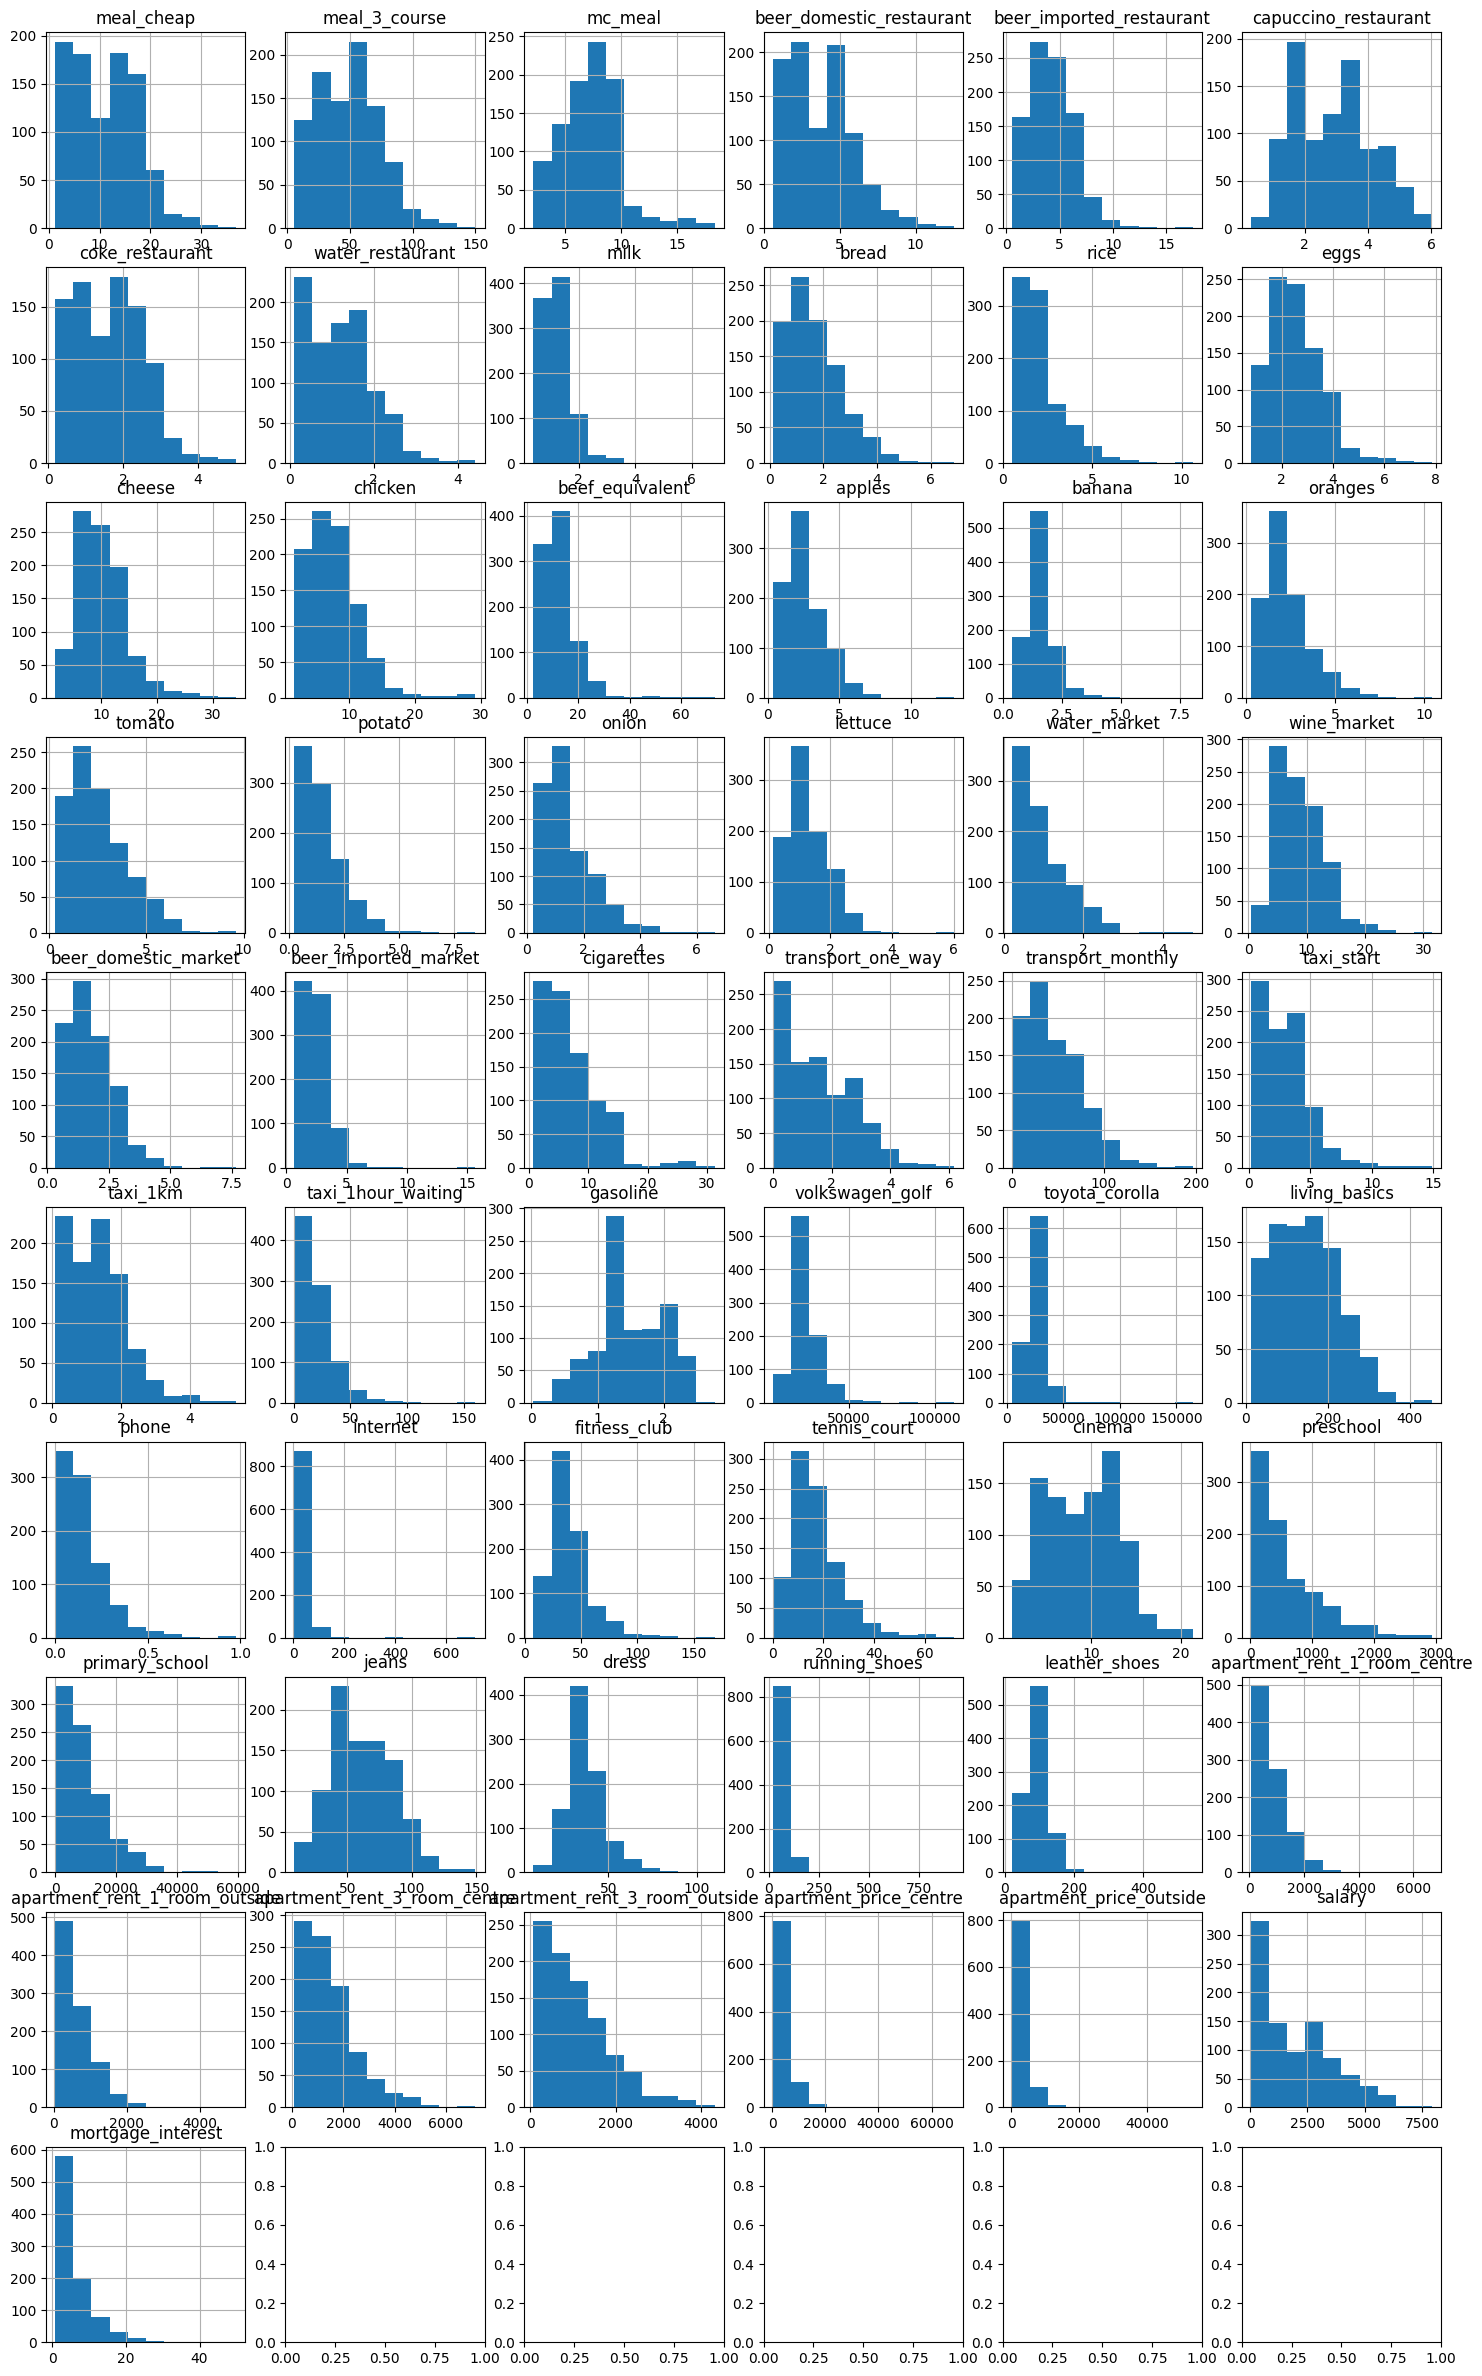

In [16]:
df_hist = df_quality.select_dtypes(include='float')
n_plots = df_hist.shape[1]
n_cols = 6
n_rows = int(np.ceil(n_plots / n_cols))
fig, ax = plt.subplots(
    n_rows,
    n_cols,
    squeeze=True,
    figsize=(3*n_cols, 3*n_rows)
)
ax.resize((ax.size,))

for i in range(n_plots):
    df_hist.iloc[:, i].hist(ax=ax[i])
    ax[i].set_title(df_hist.columns[i])
# end for

We can also draw a heatmap of the correlation values.

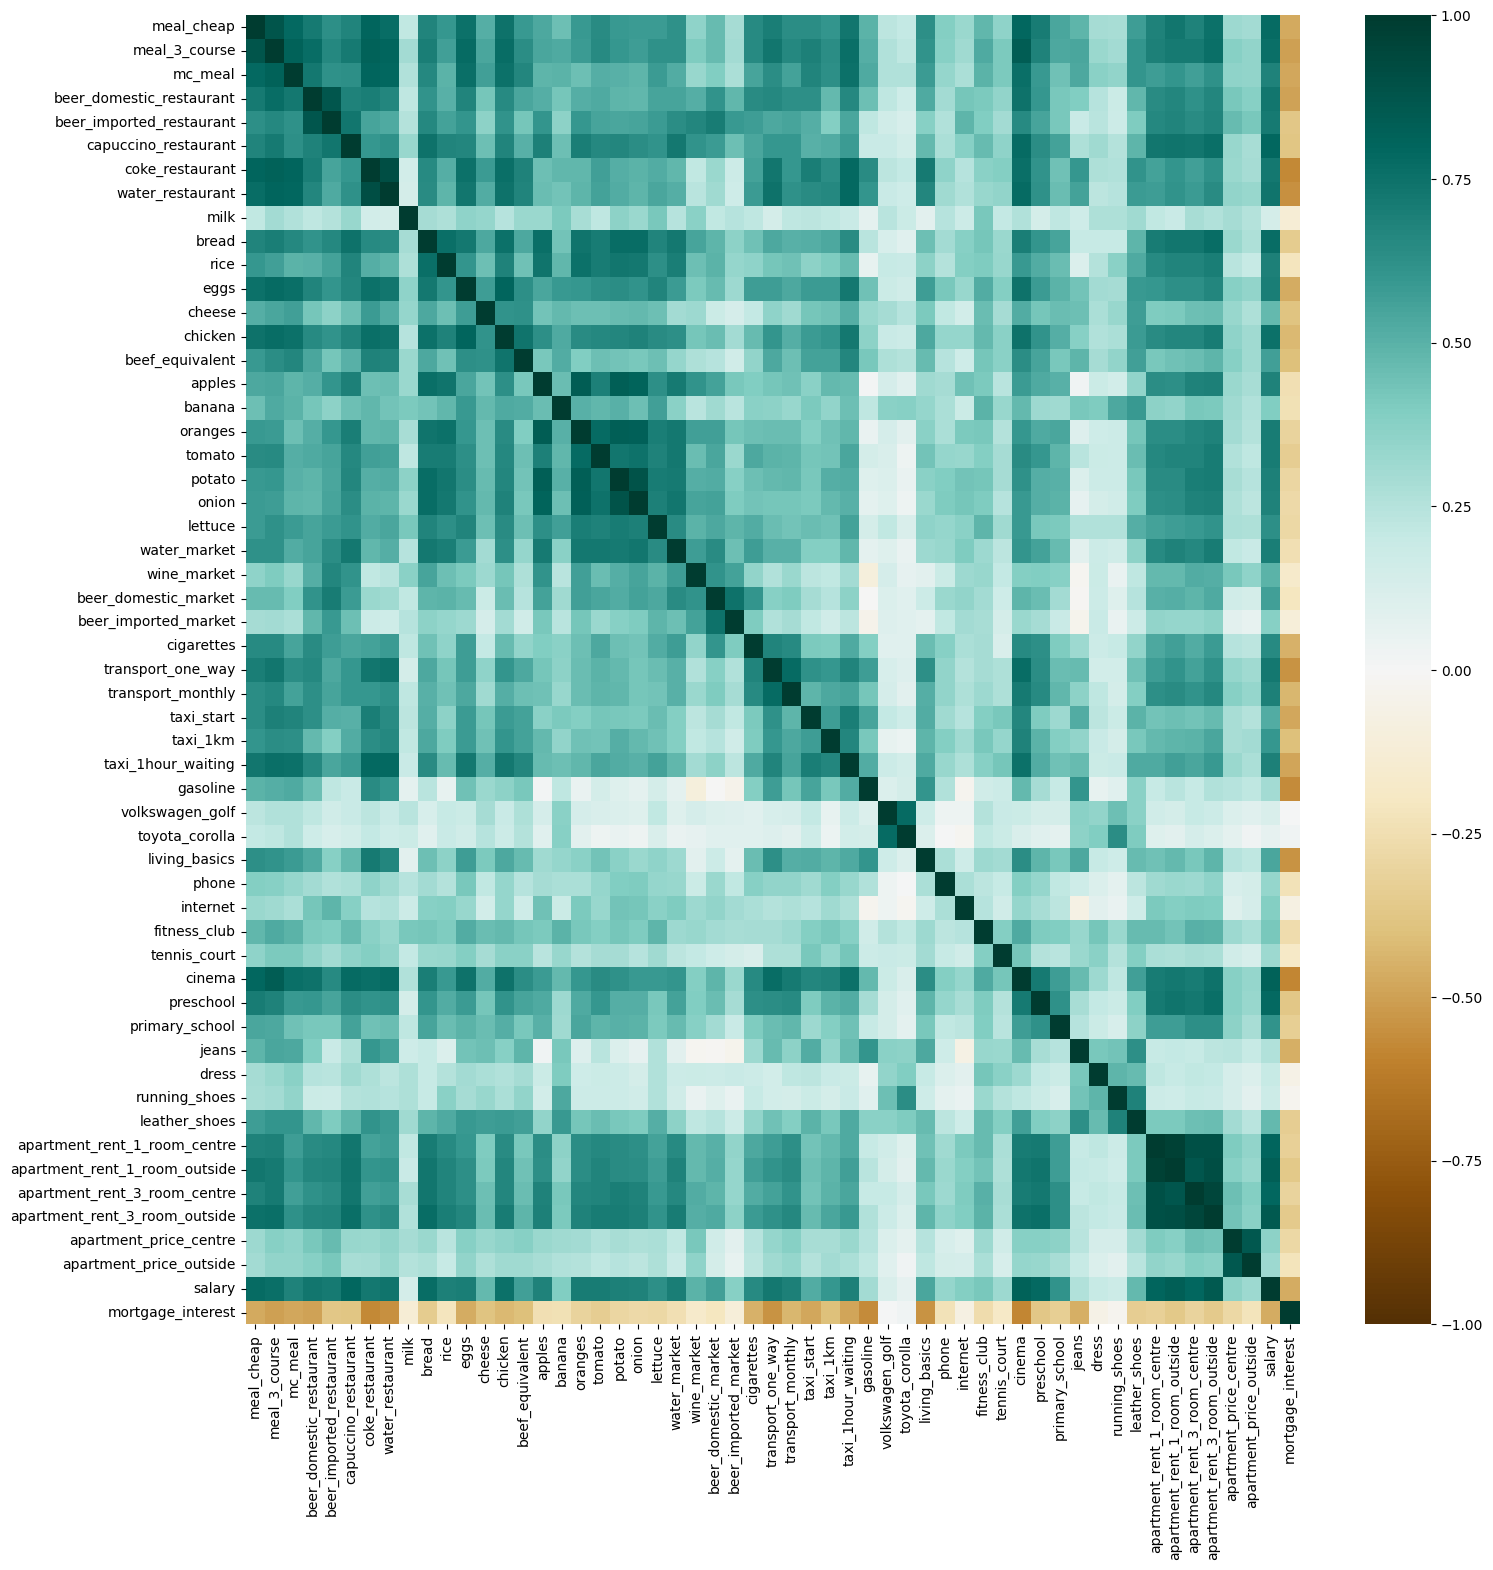

In [17]:
# correlation heatmap
plt.figure(figsize=(17, 17))
sns.heatmap(
    df_hist.corr(numeric_only=True),
    annot=False,
    cmap='BrBG',
    vmin=-1,
    vmax=1
)
plt.show()

This shows how highly correlated the numerical columns in the dataset are.

We can see that appartment rents are highly correlated. 
This means: the higher the rents for 1-room apartments in the city centre are, the higher the rents outside city centre and for 3-room apartments.
Interestingly the buying prices do not show the same high correlation with rents.

## Further Analysis

Let's see where the rental prices for apartments are the highest and therefore answer the first question:

**In which countries are the apartment prices the highest?**

In [18]:
cols = [
    'country',
    'apartment_rent_1_room_centre',
    'apartment_rent_1_room_outside',
    'apartment_rent_3_room_centre',
    'apartment_rent_3_room_outside',
    'apartment_price_centre',
    'apartment_price_outside',
]
print('Are there na values in the analyzed columns? {}'.format(
    na_check(df_quality, cols)
))

# drop the rows with na values
df_apartment_prices = df_quality.loc[:, cols].dropna(axis=0, how='any')

# mean apartment prices and rent grouped by country
mean_apartment_prices = df_apartment_prices.groupby('country').mean()
mean_apartment_prices.head()

# Which countries are in the Top 15 for all categories
n_largest = 15
countries_high_prices = set(mean_apartment_prices.index)
for col in cols[1:]:
    countries_high_prices = (
        countries_high_prices &
        set(mean_apartment_prices.nlargest(n_largest, col).index)
    )
# end for
print(sorted(countries_high_prices))

Are there na values in the analyzed columns? True
['Gibraltar', 'Hong Kong', 'Jersey', 'Luxembourg', 'Singapore', 'Switzerland']


Looks like 6 countries are amoung the most expensive apartments in all categories!
* Gibraltar,
* Hong Kong, 
* Jersey, 
* Luxembourg, 
* Singapore and
* Switzerland.

Let's call them `GHJLSS` and do some plots to compare them with the rest!

apartment_rent_3_room_outside


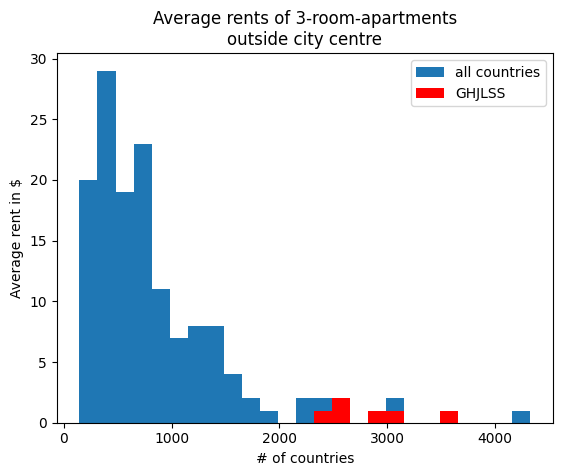

In [19]:
# ### create and save histogram ###

fig, ax = plt.subplots(1, 1)

# choose and print out column
hist_col = cols[4]
print(hist_col)

# define save name and legend labels
save_name = 'fig\\hist_{}'.format(hist_col)
label_1 = 'all countries'
label_2 = 'GHJLSS'

# get data for histogram 1
y_1 = mean_apartment_prices.loc[:, hist_col]

# get data for histogram 2
idx_high_prices = mean_apartment_prices.index.isin(countries_high_prices)
y_2 = mean_apartment_prices.loc[idx_high_prices, hist_col]

# plot histogram 1
hist_1 = plt.hist(
    y_1,
    bins=25,
    label=label_1
)

# plot histogram 2
hist_2 = plt.hist(
    y_2,
    bins=hist_1[1],
    color='red',
    label=label_2
)

# set title and axes labels
ax.set_title('Average rents of 3-room-apartments\noutside city centre')
ax.set_xlabel('# of countries')
ax.set_ylabel('Average rent in $')

# create legend
ax.legend()

# update and save figure
plt.savefig(save_name)
plt.show()

Those countries really seem to have higher average rents!
Living there must be expensive.
I wonder, if the salaries are much higher there, as well. 
This leads to our next question:

**Are the salaries particularly high in countries with high housing costs?**

For this we will create a scatter plot.
Unlike before, we won't use an average rent of different countries.

Instead, we show the average city rent dependent on the average city salary.
As exemplary rent, we here use the rent of 3-room-apartments.
To distinguish the cities of the `GHJLSS` countries from the others, we will give them colored markers.

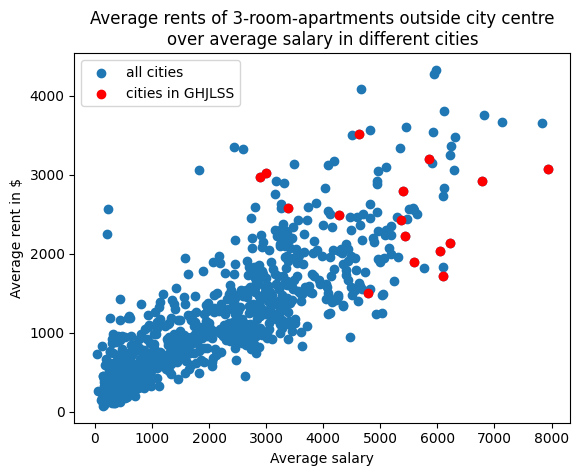

In [20]:
# ### create and save scatter plot ###

# get the relevant columns
scatter_data = df_quality.loc[:, ['salary', hist_col]]

# define save name and legend labels
save_name = 'fig\\scatter_{}'.format(hist_col)
label_1 = 'all cities'
label_2 = 'cities in GHJLSS'

# get data for scatter plot 1
x_1 = scatter_data.iloc[:, 0]
y_1 = scatter_data.iloc[:, 1]

# get data for scatter plot 2
idx_high_prices = df_quality.loc[:, 'country'].isin(countries_high_prices)
x_2 = scatter_data.loc[idx_high_prices].iloc[:, 0]
y_2 = scatter_data.loc[idx_high_prices].iloc[:, 1]

# create figure
fig, ax = plt.subplots(1, 1)

# scatter plot 1
ax.scatter(
    x_1,
    y_1,
    label=label_1
)

# scatter plot 2
ax.scatter(
    x_2,
    y_2,
    c=['#ff0000'],
    label=label_2
)

# set title and axes labels
ax.set_title(('Average rents of 3-room-apartments outside city centre'
              '\nover average salary in different cities'))
ax.set_xlabel('Average salary')
ax.set_ylabel('Average rent in $')

# create legend
ax.legend()

# update and save figure
plt.savefig(save_name)
plt.show()

Conclusion: 

We can see a strong linear correlation between salary and the rental prices of 3-room-apartments outside city centres. 
The `GHJLSS` countries have medium to very high salaries. 
The `GHJLSS` data points do not seem to be outliers.
Interestingly the highest salary in the data set is included in the 6 countries.

At first glance, one could conclude that in fact the salaries are higher in countries with high housing costs.
However, they are not particularly high.



# Data Preparation

We now want to create a model to precict the salary based on the other features.
This shall answer the last question:
*What dependencies exist between the mean salary and costs of living in the cities?*
For this we need to clean the data.

Later we want to execute a grid search on some influence factors, which is why we will implement it in a pipeline.

For the na values in the data and handling categorical values, two new transformers where created.
Those are used in the pipeline.

Here is some additional information on the two transformers:

**Categorial transformer:**
Only the columns `city`, `country` and `continent` contain categoricals in this dataset contain and have no missing values.
Therefore, they are only transformed into numericals using *one-hot-encoding*.

The column `city` will be dropped completely before the dataset is used in the pipeline since it only contains unique values.
However, there are many different values for the countries and continents. 
This might not be useful for the model.
With the grid search, the best amount of used categories `max_categories` is determined.
All other countries are stored in a so-called *infrequent class*.

Furthermore, the `continent` column can be dropped.
Pre-tests suggest to keep it.

**Numerical transformer:** 
There are some na values in the numericals.
The `NumericalTransformer` has 2 main parameters:
* `impute_method`: Can be set to `mean` or `median`. Pre-tests suggest to use mean.
* `max_na_share`: Maximum share of na-values until a column is dropped. Pre-tests suggest to keep all columns, so it's set to 1 here.

Feel free to play around with the pipeline parameters to determine a better modeling result.

In [21]:
# generate pipeline
pipe = Pipeline([
    # 1 preprocessing
    ('preprocessing', FeatureUnion([
        # .1 handle categoricals
        ('categorical_pipe', Pipeline([
            # .1 drop continent columns or not
            ('drop_cat_cols', CategoricalTransformer()),
            # .2 one-hot-encoding
            ('one_hot', OneHotEncoder(sparse_output=False,
                                      handle_unknown='infrequent_if_exist'))
        ])),
        # .2 handle numericals
        ('numerical_pipe', Pipeline([
            # .1 handle na values
            ('num_na_handling', NumericalTransformer()),
            # .2 polynomial features only for numericals
            ('polynomial', PolynomialFeatures())
        ]))
    ])),
    # 2 choose a standardizer
    ('scaler', StandardScaler()),  # might be changed in the grid search
    # 3 model kind
    ('model', LassoCV())  # might be changed in the grid search
])

In [22]:
# print out the pipeline parameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'scaler', 'model', 'preprocessing__n_jobs', 'preprocessing__transformer_list', 'preprocessing__transformer_weights', 'preprocessing__verbose', 'preprocessing__categorical_pipe', 'preprocessing__numerical_pipe', 'preprocessing__categorical_pipe__memory', 'preprocessing__categorical_pipe__steps', 'preprocessing__categorical_pipe__verbose', 'preprocessing__categorical_pipe__drop_cat_cols', 'preprocessing__categorical_pipe__one_hot', 'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent', 'preprocessing__categorical_pipe__one_hot__categories', 'preprocessing__categorical_pipe__one_hot__drop', 'preprocessing__categorical_pipe__one_hot__dtype', 'preprocessing__categorical_pipe__one_hot__handle_unknown', 'preprocessing__categorical_pipe__one_hot__max_categories', 'preprocessing__categorical_pipe__one_hot__min_frequency', 'preprocessing__categorical_pipe__one_hot__sparse', 'preprocessing__categorical_pipe__one_hot__sparse_ou

In [23]:
# define parameters for grid search
params = {
    # # min frequency of categories for one-hot-encoding
    # 'preprocessing__categorical_pipe__one_hot__min_frequency': [10],
    # max number of categories for one-hot-encoding  # list(range(85, 115)),
    'preprocessing__categorical_pipe__one_hot__max_categories':
        list(range(90, 100)),
    # drop continent column
    'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent':
        [False],
    # impute method,
    'preprocessing__numerical_pipe__num_na_handling__impute_method':
        ['mean'],  # 'median',
    # max_na_share
    'preprocessing__numerical_pipe__num_na_handling__max_na_share':
        [1],
    # polynomial degree
    'preprocessing__numerical_pipe__polynomial__degree':
        [1],
    # scaler
    'scaler':
        [StandardScaler()],
        # , Normalizer(), QuantileTransformer(), PowerTransformer()],
    # model
    'model':
        [LassoCV(tol=1e-2)],  # , LinearRegression()]
}

# create grid search
grid = GridSearchCV(pipe, param_grid=params)

In [24]:
col_target = 'salary'
# drop the na values in salary
df_quality = df_quality.dropna(axis=0, subset=col_target)

# drop cities column since it only contains unique values
try:
    df_quality = df_quality.drop('city', axis=1)
except KeyError:  # if city column is already removed
    pass
# end try

X = df_quality.drop(col_target, axis=1)
y = df_quality.loc[:, col_target]

# fit grid serach
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('categorical_pipe',
                                                                        Pipeline(steps=[('drop_cat_cols',
                                                                                         CategoricalTransformer()),
                                                                                        ('one_hot',
                                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                       sparse_output=False))])),
                                                                       ('numerical_pipe',
                                                                        Pipeline(steps=[('num_na_handling',
                                                                                         NumericalTransformer()),
                                                                                        ('polynomial',
                                                                                         Polyno...
                         'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent': [False],
                         'preprocessing__categorical_pipe__one_hot__max_categories': [90,
                                                                                      91,
                                                                                      92,
                                                                                      93,
                                                                                      94,
                                                                                      95,
                                                                                      96,
                                                                                      97,
                                                                                      98,
                                                                                      99],
                         'preprocessing__numerical_pipe__num_na_handling__impute_method': ['mean'],
                         'preprocessing__numerical_pipe__num_na_handling__max_na_share': [1],
                         'preprocessing__numerical_pipe__polynomial__degree': [1],
                         'scaler': [StandardScaler()]})

In [25]:
# print out the best pipeline parameter combination and the score
print(grid.best_params_)
print(grid.best_score_)

{'model': LassoCV(tol=0.01), 'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent': False, 'preprocessing__categorical_pipe__one_hot__max_categories': 94, 'preprocessing__numerical_pipe__num_na_handling__impute_method': 'mean', 'preprocessing__numerical_pipe__num_na_handling__max_na_share': 1, 'preprocessing__numerical_pipe__polynomial__degree': 1, 'scaler': StandardScaler()}
0.8825217671699057


(0.87, 0.89)

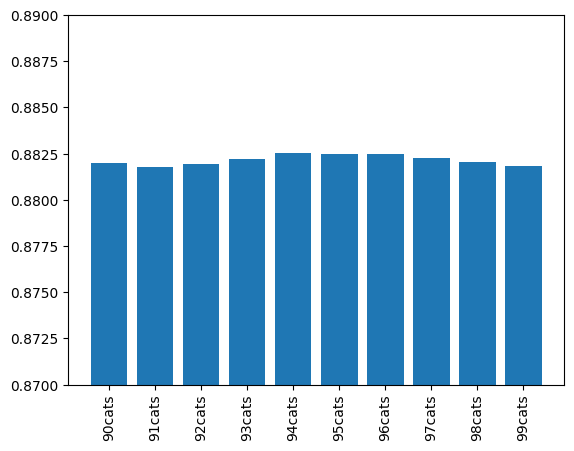

In [26]:
# create a bar plot for the mean test score over the number of categories
mean_score = grid.cv_results_['mean_test_score']
max_cat = grid.cv_results_[
    'param_preprocessing__categorical_pipe__one_hot__max_categories'
]
tick_label = ['{}cats'.format(x) for x in max_cat]

x = range(len(mean_score))

fig, ax = plt.subplots()
ax.bar(x, mean_score)
ax.set_xticks(x)
ax.set_xticklabels(tick_label)
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylim(bottom=.87, top=.89)

Let's train the final model once again with a fixed test and train set.


In [27]:
# test_train_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.3,
    random_state=global_random_state
)

# build pipeline
final_pipe = grid.best_estimator_

# fit model
final_pipe.fit(X_train, y_train)

# print out train and test score
train_score = final_pipe.score(X_train, y_train)
test_score = final_pipe.score(X_test, y_test)
print('Train score R2 is: {}'. format(
    train_score
))
print('Test score R2 is: {}'. format(
    test_score
))

Train score R2 is: 0.9205503773372187
Test score R2 is: 0.9188477422012364


In [28]:
# predictions on the train and test set
y_train_pred = final_pipe.predict(X_train)
y_test_pred = final_pipe.predict(X_test)

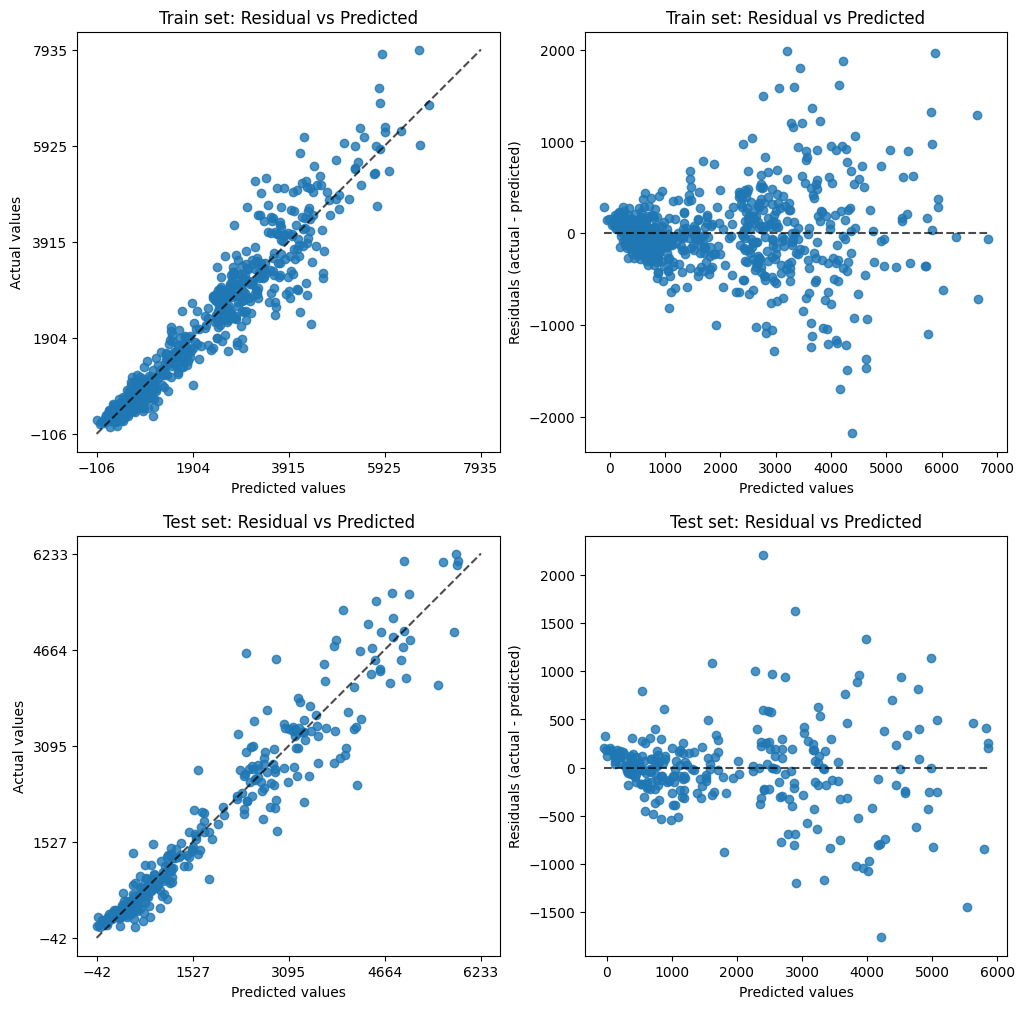

In [29]:
# plot true vs. predicted value
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))


def custom_error_plot(ax, plot_train, plot_residual):
    """
    Function plots an arror plot in axis ax depending on the inputs:
      - plot_train: bool, use train or test error
      - plot_residual: bool, plot 'residual_vs_predicted' or
        'actual_vs_predicted'
    """
    if plot_train:
        test_train_str = 'Train'
        y = y_train
        y_pred = y_train_pred

    else:
        test_train_str = 'Test'
        y = y_test
        y_pred = y_test_pred
    # end if

    if plot_residual:
        kind_str = 'residual_vs_predicted'
        title_kind_str = 'Residual vs Predicted'

    else:
        kind_str = 'actual_vs_predicted'
        title_kind_str = 'Residual vs Predicted'
    # end if

    title_str = '{} set: {}'.format(
        test_train_str,
        title_kind_str
    )

    # set axis title
    ax.set_title(title_str)

    _ = PredictionErrorDisplay.from_predictions(
        y,
        y_pred,
        kind=kind_str,
        ax=ax,
        subsample=None
    )

    return
# end def


# ### Figures with the train set ###
# actual vs predicted
custom_error_plot(axs[0][0], plot_train=True, plot_residual=False)

# residual vs predicted
custom_error_plot(axs[0][1], plot_train=True, plot_residual=True)

# ### Figures with the test set ###
# actual vs predicted
custom_error_plot(axs[1][0], plot_train=False, plot_residual=False)

# residual vs predicted
custom_error_plot(axs[1][1], plot_train=False, plot_residual=True)

The plot above shows that the residuals are normally distributed.
They increase with rising salaries.

In general, we now have an adequate model and can answer the last question:

**What dependencies exist between the mean salary and costs of living in the cities?**

Let's plot the most important positive and negative features for the model for that!

Number of features: 155
Number of coefficients: 155


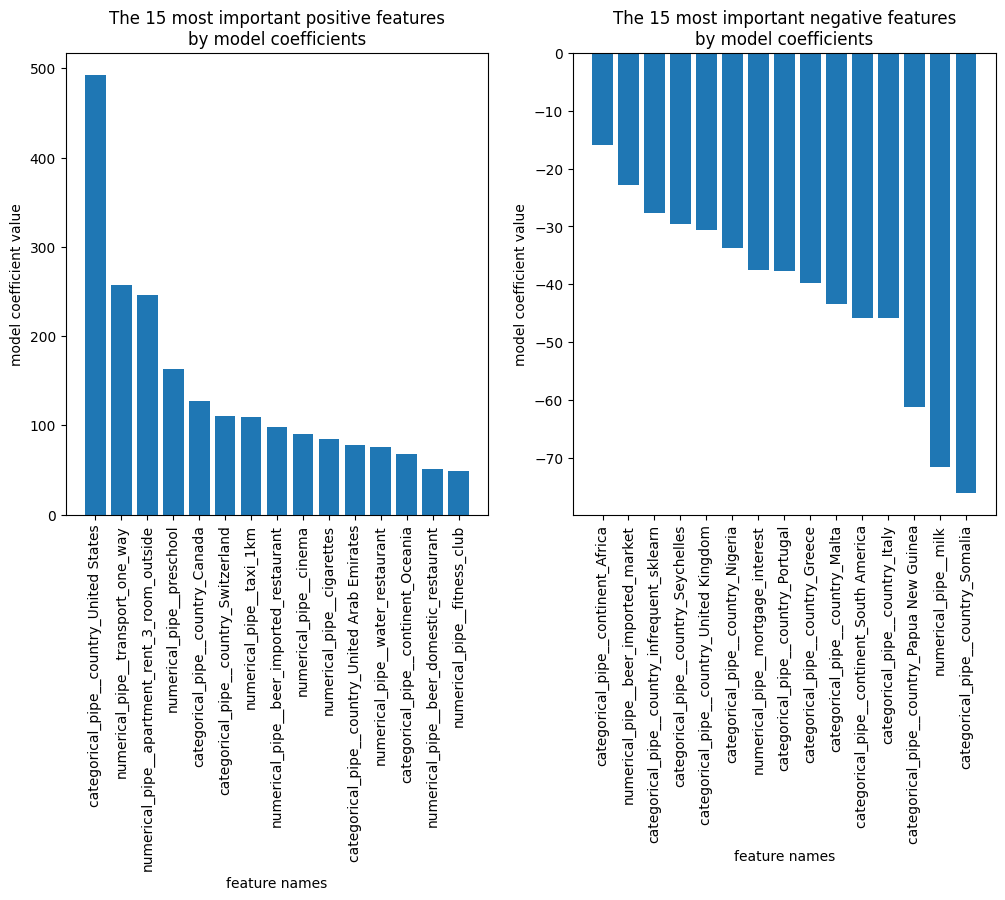

In [30]:
# get feature importance and names
final_model = final_pipe.named_steps['model']
model_coefs = final_model.coef_
importance = np.abs(model_coefs)
feature_names = final_pipe.named_steps['preprocessing'].get_feature_names_out()

# quick sanity check
print('Number of features: {}'.format(len(feature_names)))
print('Number of coefficients: {}'.format(len(model_coefs)))

# sort feature names and importance by descending importance
idx_sort = model_coefs.argsort()
model_coefs_sorted = np.flip(model_coefs[idx_sort])
feature_names_sorted = np.flip(feature_names[idx_sort])

n_bars = 15  # plot only n_bars bars

# create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# common axes label names
xlabel = 'feature names'
ylabel = 'model coefficient value'

# bar plot 1
ax[0].bar(height=model_coefs_sorted[:n_bars], x=feature_names_sorted[:n_bars])
ax[0].set_title(("The {} most important positive features\n"
                 "by model coefficients").format(n_bars))
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].tick_params(axis='x', labelrotation=90)

# bar plot 2
ax[1].bar(height=model_coefs_sorted[-n_bars:],
          x=feature_names_sorted[-n_bars:])
ax[1].set_title(("The {} most important negative features\n"
                 "by model coefficients").format(n_bars))
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel(ylabel)
ax[1].tick_params(axis='x', labelrotation=90)

# update and save figure
plt.savefig(
    r'fig\bar_features',
    bbox_inches="tight"
)
plt.show()

So to sum it up:
The biggest influence on salary is the country (and therefore continent) you live in.
Besides that there are some other factors that play an important role like:
* public transport, 
* taxi costs and 
* the costs of milk.

In general, there are strong correlations between the costs of living and the mean salaries in the cities of the dataset.
So pick your next city wisely. 😉



## Afterlude

Below, I want to check whether the results are plausible in the model and the features are not messed up.

In [31]:
# input to test the milk component
df_milk = df_quality.mode().iloc[0, :].to_frame().T
df_milk = df_milk.convert_dtypes(convert_string=False)
df_milk = pd.concat([df_milk]*2)
df_milk = df_milk.set_index(pd.Index(['min', 'max']))
df_milk.loc['min', 'milk'] = df_quality.loc[:, 'milk'].min()
df_milk.loc['max', 'milk'] = df_quality.loc[:, 'milk'].max()

df_milk = df_milk.loc[:, X_train.columns]
print(df_milk.loc[:, 'milk'])
final_pipe.predict(df_milk)
# final_pipe.predict(X_test.iloc[0,:].to_frame().T.convert_dtypes(convert_string=False))

min     0.4
max    6.81
Name: milk, dtype: Float64


array([3483.87880168, 2644.58493134])

Seems like the prediction matches the expecation of the figure above.